# Polynomial Transport Maps for Variational Inference using KLD

In [1]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.linear import Linear
from nflows.transforms.linear import NaiveLinear

from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

from nflows.transforms.autoregressive import MaskedPiecewiseCubicAutoregressiveTransform
from nflows.transforms.nonlinearities import Sigmoid
from nflows.transforms.nonlinearities import Logit

import scipy.special

plt.rcParams['figure.figsize'] = [12,12]

## Introduction

This notebook extends a triangular polynomial transport map for variational inference using the Kulback Leibler Divergence (KLD). Polynomial transports are covered in https://arxiv.org/pdf/1602.05023.pdf.

The examples in this notebook will be applied to a random vector $\boldsymbol{x} \in \mathbb{R}^2$. In this instance, the polynomial transport map $T: \mathbb{R}^2 \rightarrow \mathbb{R}^2$ is such that

$$
    T (\boldsymbol{x}) = \begin{bmatrix}
        T^1 (x_1) \\
        T^2 (x_1, x_2)
    \end{bmatrix}.
$$

Here, we use a polynomial representation for $T$, which is outlined in Section 5.1 of the aforementioned article. The polynomial representation is parameterised by a coefficient vector $\boldsymbol{\theta}$, which can be optimised via gradient descent methods. The $\theta$ parameterised transport map $T_\theta (\boldsymbol{x})$ takes the form

$$
    T_\theta (\boldsymbol{x}) = \begin{bmatrix}
        \sum_{l=0}^p \theta_{1l} x_1^l \\
        \sum_{l=1}^p \sum_{k=0}^{p-l} \theta_{2lk} x_1^l x_2^k
    \end{bmatrix}
$$

where

$$
    \boldsymbol{\theta} \equiv \left(
        \theta_{10}, \dots, \theta_{1p},
        \theta_{200}, \dots, \theta_{20p},
        \theta_{210}, \dots, \theta_{21(p-1)},
        \dots, \theta_{2p0}
    \right)^\intercal
$$

and $p$ is the order of the polynomial parameterisation. Below, we introduce the polynomial transport map:

In [2]:
def theta_init(order):
    
    theta_1 = torch.zeros(order + 1)
    theta_1[1] = 1.
    
    n = order + 1.
    r = 2
    numer = torch.from_numpy(np.arange(1,(n + r))).prod()
    denom = torch.from_numpy(np.arange(1,(n + r - 2))).prod()*torch.from_numpy(np.arange(1,3)).prod()
    d_theta_2 = (numer/denom).type(torch.LongTensor)
    theta_2 = torch.zeros(d_theta_2)
    theta_2[1] = 1.
    
    theta = torch.cat([theta_1, theta_2])
    theta.requires_grad=True
    
    return theta

def T_theta(x, theta, order):
    
    N = x.size()[0]
    
    len_theta = len(theta)
    theta = theta.reshape(len_theta, 1)
    
    x_1 = x[:,0].reshape(N, 1)
    x_2 = x[:,1].reshape(N, 1)
    
    X_1 = []
    for i in range(order + 1):
        
        x_1_powers = x_1**i
        X_1.append(x_1_powers)
    
    X_1 = torch.cat(X_1, dim=1)
    
    seq = torch.from_numpy(np.arange(1,(order+1)))
    seq = torch.cat([torch.tensor([0]), seq])
    
    combns = torch.combinations(seq, with_replacement=True)
    n_row = combns.size()[0]
    combns_1 = combns[:,0].reshape(n_row, 1)
    combns_2 = combns[:,1].reshape(n_row, 1)
    combns_rev = torch.cat([combns_2, combns_1], dim=1)
    neq_rows = (combns_1!=combns_2).reshape(n_row)
    combns_rev = combns_rev[neq_rows,:]
    
    combns = torch.cat([combns, combns_rev], dim=0)
    sum_crit = (combns.sum(dim=1) <= order)
    combns = combns[sum_crit,:]
    n_combns = combns.size()[0]
    
    for i in seq:
        
        combns_i = combns[combns[:,0]==i,:]
        sorted_combns_i, _ = torch.sort(combns_i[:,1])
        combns[combns[:,0]==i,1] = sorted_combns_i
    
    combns_array = []
    for i in seq:
    
        sub_tensor = combns[combns[:,0]==i,:]
        combns_array.append(sub_tensor)
    
    combns = torch.cat(combns_array, dim = 0)
    
    X_2 = []
    for i in range(n_combns):
        
        powers = combns[i,:]
        x_1_powers = x_1**(powers[0])
        x_2_powers = x_2**(powers[1])
        mult_vec = x_1_powers*x_2_powers
        X_2.append(mult_vec)
    
    X_2 = torch.cat(X_2, dim=1)
    
    n_col_X_1 = X_1.size()[1]
    n_col_X_2 = X_2.size()[1]
    
    zero_mat_1 = torch.zeros(N, n_col_X_2)
    zero_mat_2 = torch.zeros(N, n_col_X_1)
    X_1 = torch.cat((X_1, zero_mat_1), dim=1)
    X_2 = torch.cat((zero_mat_2, X_2), dim=1)
    
    X = torch.cat((X_1, X_2), dim = 1).reshape(2*N, len_theta)
    
    T_theta_mat = torch.mm(X, theta).reshape(N, 2)
    return T_theta_mat

## Approximating the KLD

We can approximate the KLD with a Monte Carlo sum:

$$
    \text{KLD} \{ T(Q), P \} \approx -\frac{1}{M} \sum_{i=1}^M\left[
        \log \overline{\pi} \{ T (\boldsymbol{x}_i) \}
        + \sum_{j=1}^n \log \left| \partial_j T_\theta^j (\boldsymbol{x}_i) \right|
    \right],
$$

where

$$
    \partial_1 T_\theta^1 (x_1) = \sum_{l=1}^p l \theta_{1l} x_1^{l-1} \\
    \partial_2 T_\theta^2 (x_1, x_2) = \sum_{l=1}^{p-1} \sum_{k=1}^{p-l} k \theta_{2lk} x_1^l x_2^{k-1}
$$

and $\overline{\pi}$ is an unnormalised version of the target distribution's probability density function. We define the KLD below:

In [3]:
def loss_KLD(x, theta, T_x, order, log_pi_bar):
    
    x_1 = x[:,0]
    x_2 = x[:,1]
    
    theta_1 = theta[0:(order+1)]
    theta_2 = theta[(order+1):]
    
    grad_T_x_1 = 0.
    l_range = torch.tensor(range(order)) + 1
    for l in l_range:
        
        grad_T_x_1 += l*theta_1[l]*(x_1**l)
    
    grad_T_x_2 = 0.
    count_start = 0
    l_range = torch.tensor(range(order))
    for l in l_range:

        count_end = count_start + order + 1 - l
        theta_2_l = theta_2[count_start:count_end]
        k_range = torch.tensor(range(order - l)) + 1
        for k in k_range:

            grad_T_x_2 += k*theta_2_l[k]*(x_1**l)*(x_2**(k-1))

        count_start = count_end
    
    log_abs_det_grad_T_x = grad_T_x_1.abs().log() + grad_T_x_2.abs().log()
    KLD_val = -(log_pi_bar(T_x) + log_abs_det_grad_T_x).mean()
    
    return KLD_val

## Base Distribution

The base distribution for all simulations will be a $\mathcal{N} (\textbf{0}, \textbf{I})$:

In [4]:
mu_Q = torch.zeros(2)
Sigma_Q = torch.eye(2)
base_dist = MultivariateNormal(mu_Q, Sigma_Q)

## Transport to a Gaussian

Let's start with an arbitrary $\mathcal{N} (\mu, \Sigma)$ target. In this instance, a linear transport map will be sufficient.

In [5]:
mu_P = torch.tensor([3., -4.])
Sigma_P = torch.tensor([[2., -0.5], [-0.5, 1.5]])
target_dist = MultivariateNormal(mu_P, Sigma_P)
log_pi_bar = target_dist.log_prob

Next, we set up a plotting and sampling function for the Gaussian distribution:

In [6]:
def plot_gauss(mu, Sigma, x_lim, y_lim, n_levs):
    
    x_min = x_lim[0]
    x_max = x_lim[1]
    
    y_min = y_lim[0]
    y_max = y_lim[1]
    
    x_line = torch.linspace(x_min, x_max)
    y_line = torch.linspace(y_min, y_max)
    
    x_g, y_g = torch.meshgrid(x_line, y_line)
    xy_g = torch.cat([x_g.reshape(-1, 1), y_g.reshape(-1, 1)], dim=1)
    
    with torch.no_grad():
        gauss_dist = MultivariateNormal(mu, Sigma)
        pdf_g = gauss_dist.log_prob(xy_g).exp().reshape(100,100)
    
    plt.contourf(x_g.numpy(), y_g.numpy(), pdf_g.numpy(), levels = n_levs)



def sample_gauss(N, mu, Sigma):
    
    gauss_dist = MultivariateNormal(mu, Sigma)
    gauss_samp = gauss_dist.sample((N,))
    
    return gauss_samp

Now, we implement SGD with the KLD:

In [7]:
# Set the algorithm parameters:
n_iter = 10000
N = 100
poly_order = 1

# Initialise theta:

theta = theta_init(poly_order)

# Establish the optimizer:

optimizer = optim.Adam([theta])

# Run the SGD algorithm:

for i in range(n_iter):
    
    # random sample:
    x = base_dist.sample((N,))

    # transport:
    T_x = T_theta(x, theta, poly_order)

    # loss:
    loss = loss_KLD(x, theta, T_x, poly_order, log_pi_bar)

    # gradient:
    loss.backward()

    # SGD step:
    optimizer.step()

    # zero gradients:
    optimizer.zero_grad()
    
    if (i + 1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss.item()))

iteration: 500, loss: 8.158145904541016
iteration: 1000, loss: 6.4075188636779785
iteration: 1500, loss: 5.8593974113464355
iteration: 2000, loss: 5.653444290161133
iteration: 2500, loss: 4.432502746582031
iteration: 3000, loss: 4.280048370361328
iteration: 3500, loss: 4.053032398223877
iteration: 4000, loss: 3.8075647354125977
iteration: 4500, loss: 3.6154990196228027
iteration: 5000, loss: 3.450221300125122
iteration: 5500, loss: 3.532238483428955
iteration: 6000, loss: 3.576371431350708
iteration: 6500, loss: 3.497035026550293
iteration: 7000, loss: 3.598973274230957
iteration: 7500, loss: 3.3868837356567383
iteration: 8000, loss: 3.4949700832366943
iteration: 8500, loss: 3.408217668533325
iteration: 9000, loss: 3.464017868041992
iteration: 9500, loss: 3.4125428199768066
iteration: 10000, loss: 3.581918239593506


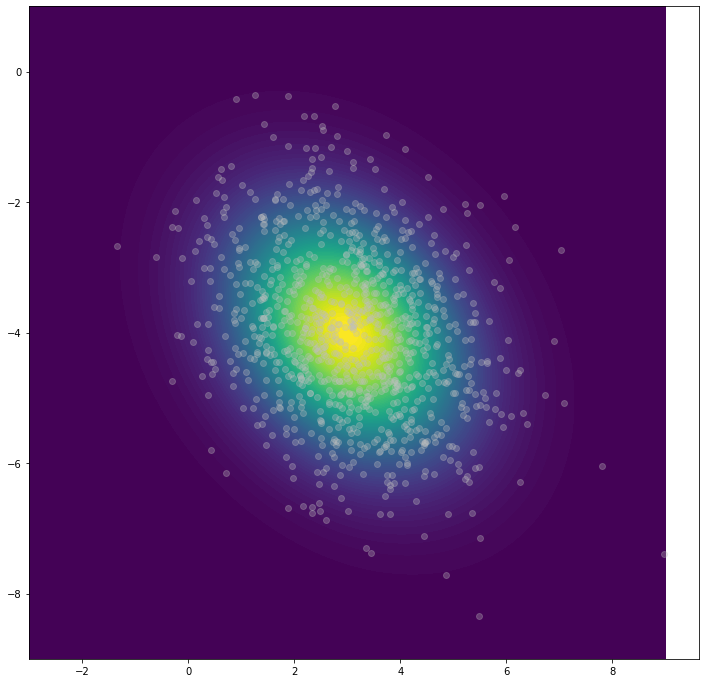

In [8]:
N = 1000

Q_sample = base_dist.sample((N,))
T_Q_sample = T_theta(Q_sample, theta, poly_order)
T_Q_sample = T_Q_sample.detach().numpy()

x_lim = torch.tensor([-3, 9])
y_lim = torch.tensor([-9, 1])
n_levs = 100
N = 1000

plot_gauss(mu_P, Sigma_P, x_lim, y_lim, n_levs)
plt.scatter(np.transpose(T_Q_sample)[0], np.transpose(T_Q_sample)[1], color='silver', alpha=0.3)

## Transport to a Banana Distribution

Let's start with an arbitrary $\text{Banana} (a, \sigma_1^2, \sigma_2^2)$ target. In this instance, a quadratic transport map will be sufficient.

In [9]:
a = 0.2
sigma_1 = torch.tensor([2.])
sigma_2 = torch.tensor([1.3])

def log_pi_bar(x, a, sigma_1, sigma_2):
    
    x_1 = x[:,0]
    x_2 = x[:,1]
    
    x_1_log_prob = Normal(torch.tensor([0.]), sigma_1).log_prob(x_1)
    
    mu_2 = a*(x_1**2)
    x_2_log_prob = Normal(mu_2, sigma_2).log_prob(x_2)
    log_pi_bar_vec = x_1_log_prob + x_2_log_prob
    
    return log_pi_bar_vec

Next, we set up a plotting and sampling function for the Banana distribution:

In [10]:
def plot_banana(a, sigma_1, sigma_2, x_lim, y_lim, n_levs):
    
    x_min = x_lim[0]
    x_max = x_lim[1]

    y_min = y_lim[0]
    y_max = y_lim[1]

    x_line = torch.linspace(x_min, x_max)
    y_line = torch.linspace(y_min, y_max)

    x_g, y_g = torch.meshgrid(x_line, y_line)
    xy_g = torch.cat([x_g.reshape(-1, 1), y_g.reshape(-1, 1)], dim=1)

    with torch.no_grad():

        x_coords = xy_g[:,0]
        y_coords = xy_g[:,1]

        gauss_1 = Normal(torch.tensor([0.]), sigma_1)
        pdf_g_1 = gauss_1.log_prob(x_coords).exp()

        mu_2 = a*(x_coords**2)
        gauss_2 = Normal(mu_2, sigma_2)
        pdf_g_2 = gauss_2.log_prob(y_coords).exp()

        pdf_g = (pdf_g_1*pdf_g_2).reshape(100, 100)

    plt.contourf(x_g.numpy(), y_g.numpy(), pdf_g.numpy(), levels = n_levs)

def rand_banana(n, a, sigma_1, sigma_2):
    
    norm_samp_1 = torch.randn(n, 1)
    norm_samp_2 = torch.randn(n, 1)
    x_1 = sigma_1*norm_samp_1
    x_2 = a*(x_1**2) + sigma_2*norm_samp_2
    x = torch.cat((x_1, x_2), 1)
    return x

Now, we implement SGD with the KLD:

In [11]:
# Set the algorithm parameters:
n_iter = 10000
N = 100
poly_order = 2

# Set up the log target:
log_target = lambda x: log_pi_bar(x, a, sigma_1, sigma_2)

# Initialise theta:

theta = theta_init(poly_order)

# Establish the optimizer:

optimizer = optim.Adam([theta])

# Run the SGD algorithm:

for i in range(n_iter):
    
    # random sample:
    x = base_dist.sample((N,))

    # transport:
    T_x = T_theta(x, theta, poly_order)

    # loss:
    loss = loss_KLD(x, theta, T_x, poly_order, log_target)

    # gradient:
    loss.backward()

    # SGD step:
    optimizer.step()

    # zero gradients:
    optimizer.zero_grad()
    
    if (i + 1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss.item()))

iteration: 500, loss: 3.505096435546875
iteration: 1000, loss: 3.5657918453216553
iteration: 1500, loss: 3.356991767883301
iteration: 2000, loss: 3.4244539737701416
iteration: 2500, loss: 3.499453067779541
iteration: 3000, loss: 3.4743916988372803
iteration: 3500, loss: 3.348261833190918
iteration: 4000, loss: 3.6825015544891357
iteration: 4500, loss: 3.661390781402588
iteration: 5000, loss: 3.3487894535064697
iteration: 5500, loss: 3.5531363487243652
iteration: 6000, loss: 3.466740131378174
iteration: 6500, loss: 3.3137950897216797
iteration: 7000, loss: 3.398603916168213
iteration: 7500, loss: 3.4360833168029785
iteration: 8000, loss: 3.5094046592712402
iteration: 8500, loss: 3.290168046951294
iteration: 9000, loss: 3.5272140502929688
iteration: 9500, loss: 3.484720468521118
iteration: 10000, loss: 3.6453025341033936


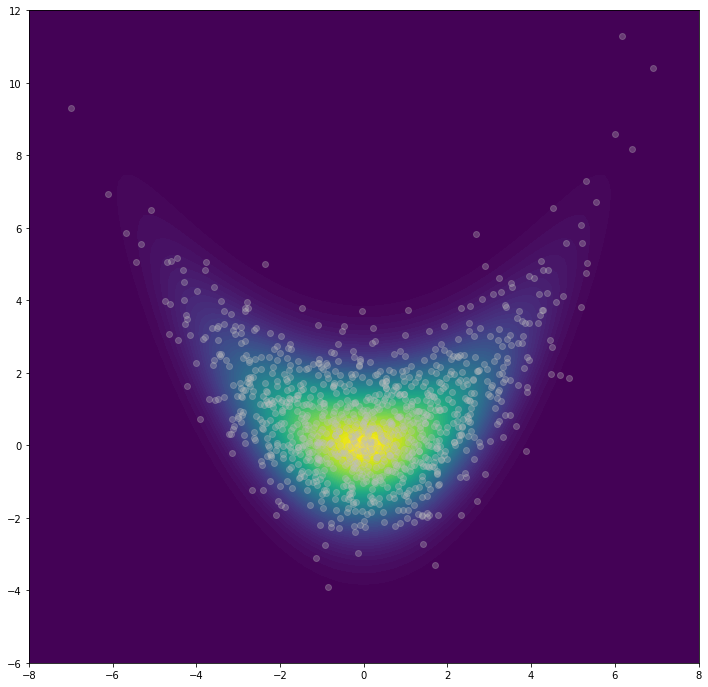

In [12]:
N = 1000

Q_sample = base_dist.sample((N,))
T_Q_sample = T_theta(Q_sample, theta, poly_order)
T_Q_sample = T_Q_sample.detach().numpy()

x_lim = torch.tensor([-8, 8])
y_lim = torch.tensor([-6, 12])
n_levs = 100
N = 1000

plot_banana(a, sigma_1, sigma_2, x_lim, y_lim, n_levs)
plt.scatter(np.transpose(T_Q_sample)[0], np.transpose(T_Q_sample)[1], color='silver', alpha=0.3)

## Transport to a Sinusoidal Distribution

Let's start with an arbitrary $\text{Sinusoidal} (a, \sigma_1^2, \sigma_2^2)$ target. In this instance, a cubic transport map will be necessary.

In [13]:
a = 1.1
sigma_1 = 2**(0.5)
sigma_2 = 0.3**(0.5)

def log_pi_bar(x, a, sigma_1, sigma_2):
    
    x_1 = x[:,0]
    x_2 = x[:,1]
    
    x_1_log_prob = Normal(torch.tensor([0.]), sigma_1).log_prob(x_1)
    
    mu_2 = (a*x_1).sin()
    x_2_log_prob = Normal(mu_2, sigma_2).log_prob(x_2)
    log_pi_bar_vec = x_1_log_prob + x_2_log_prob
    
    return log_pi_bar_vec

Next, we set up a plotting and sampling function for the Banana distribution:

In [14]:
def plot_sin_dist(a, sigma_1, sigma_2, x_lim, y_lim, n_levs):

    x_min = x_lim[0]
    x_max = x_lim[1]

    y_min = y_lim[0]
    y_max = y_lim[1]

    x_line = torch.linspace(x_min, x_max)
    y_line = torch.linspace(y_min, y_max)

    x_g, y_g = torch.meshgrid(x_line, y_line)
    xy_g = torch.cat([x_g.reshape(-1, 1), y_g.reshape(-1, 1)], dim=1)

    with torch.no_grad():

        x_coords = xy_g[:,0]
        y_coords = xy_g[:,1]

        gauss_1 = Normal(torch.tensor([0.]), sigma_1)
        pdf_1 = gauss_1.log_prob(x_coords).exp()

        mu_2 = (a*x_coords).sin()
        gauss_2 = Normal(mu_2, sigma_2)
        pdf_2 = gauss_2.log_prob(y_coords).exp()

        pdf_g = (pdf_1*pdf_2).reshape(100, 100)


    plt.contourf(x_g.numpy(), y_g.numpy(), pdf_g.numpy(), levels = n_levs)

def rand_sin(N, a, sigma_1, sigma_2):
    
    samp_1 = torch.randn(N)
    samp_2 = torch.randn(N)

    norm_1_samp = sigma_1*samp_1
    norm_1_samp = norm_1_samp.reshape(N, 1)

    mu_2 = (a*norm_1_samp).sin()
    norm_2_samp = sigma_2*samp_2.reshape(N, 1) + mu_2

    sin_samp = torch.cat([norm_1_samp, norm_2_samp], dim=1)
    
    return sin_samp

Now, we implement SGD with the KLD:

In [ ]:
# Set the algorithm parameters:
n_iter = 10000
N = 100
poly_order = 3

# Set up the log target:
log_target = lambda x: log_pi_bar(x, a, sigma_1, sigma_2)

# Initialise theta:

theta = theta_init(poly_order)

# Establish the optimizer:

optimizer = optim.Adam([theta])

# Run the SGD algorithm:

for i in range(n_iter):
    
    # random sample:
    x = base_dist.sample((N,))

    # transport:
    T_x = T_theta(x, theta, poly_order)

    # loss:
    loss = loss_KLD(x, theta, T_x, poly_order, log_target)

    # gradient:
    loss.backward()

    # SGD step:
    optimizer.step()

    # zero gradients:
    optimizer.zero_grad()
    
    if (i + 1) % 500 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss.item()))

iteration: 500, loss: 3.9602646827697754
iteration: 1000, loss: 3.607969284057617
iteration: 1500, loss: 3.5677545070648193
iteration: 2000, loss: 3.60792875289917
iteration: 2500, loss: 3.7200968265533447
iteration: 3000, loss: 3.7002694606781006
iteration: 3500, loss: 3.677687406539917
iteration: 4000, loss: 3.6015350818634033
iteration: 4500, loss: 3.860276222229004
iteration: 5000, loss: 3.4842357635498047
iteration: 5500, loss: 3.5203096866607666


In [ ]:
N = 1000

Q_sample = base_dist.sample((N,))
T_Q_sample = T_theta(Q_sample, theta, poly_order)
T_Q_sample = T_Q_sample.detach().numpy()

x_lim = torch.tensor([-5, 5])
y_lim = torch.tensor([-6, 6])
n_levs = 100
N = 1000

plot_sin_dist(a, sigma_1, sigma_2, x_lim, y_lim, n_levs)
plt.scatter(np.transpose(T_Q_sample)[0], np.transpose(T_Q_sample)[1], color='silver', alpha=0.3)